# 9.5. 机器翻译与数据集

语言模型是自然语言处理的关键，而**机器翻译**是语言模型最成功的基准测试。因为机器翻译正是将输入序列转换成输出序列的**序列转换模型**（sequence transduction）的核心问题。序列转换模型在各类现代人工智能应用中发挥着至关重要的作用，因此我们将其做为本章剩余部分和第10章的重点。为此，本节将介绍机器翻译问题及其后文需要使用的数据集。

**机器翻译**（machine translation）指的是将序列从一种语言自动翻译成另一种语言。事实上，这个研究领域可以追溯到数字计算机发明后不久的20世纪40年代，特别是在第二次世界大战中使用计算机破解语言编码。几十年来，在使用神经网络进行端到端学习的兴起之前，统计学方法在这一领域一直占据主导地位。因为**统计机器翻译**（statisticalmachine translation）涉及了翻译模型和语言模型等组成部分的统计分析，因此基于神经网络的方法通常被称为**神经机器翻译**（neuralmachine translation），用于将两种翻译模型区分开来。

本书的关注点是神经网络机器翻译方法，强调的是端到端的学习。与8.3节中的语料库是单一语言的语言模型问题存在不同，机器翻译的数据集是由源语言和目标语言的文本序列对组成的。因此，我们需要一种完全不同的方法来预处理机器翻译数据集，而不是复用语言模型的预处理程序。下面，我们看一下如何将预处理后的数据加载到小批量中用于训练。

## 9.5.1. 下载和预处理数据集
首先，下载一个由Tatoeba项目的双语句子对组成的“英－法”数据集，数据集中的每一行都是制表符分隔的文本序列对，序列对由英文文本序列和翻译后的法语文本序列组成。请注意，每个文本序列可以是一个句子，也可以是包含多个句子的一个段落。在这个将英语翻译成法语的机器翻译问题中，英语是源语言（source language），法语是目标语言（target language）。

In [2]:
import os
import torch
from d2l import torch as d2l

#@save
d2l.DATA_HUB['fra-eng']=(d2l.DATA_URL+'fra-eng.zip','94646ad1522d915e7b0f9296181140edcf86a4f5')

#@save
def read_data_nmt():
    """载入“英语－法语”数据集"""
    data_dir=d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir,'fra.txt'),'r',encoding='utf-8') as f:
        return f.read()

raw_text=read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [4]:
"""
下载数据集后，原始文本数据需要经过几个预处理步骤。

例如，我们用空格代替不间断空格（non-breaking space）， 使用小写字母替换大写字母，并在单词和标点符号之间插入空格。
"""
#@save
def preprocess_nmt(text):
    """预处理“英语－法语”数据集"""
    def no_space(char,prev_char):
        return char in set(',.!?') and prev_char !=' '

    # 使用空格替换不间断空格,使用小写字母替换大写字母
    text=text.replace('\u202f',' ').replace('\xa0',' ').lower()
    # 在单词和标点符号之间插入空格
    out=[' '+char if i>0 and no_space(char,text[i-1]) else char for i,char in enumerate(text)]
    return ''.join(out)

text=preprocess_nmt(raw_text)
print(text[:80])


go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


## 9.5.2. 词元化
与 8.3节中的字符级词元化不同，在机器翻译中，我们更喜欢单词级词元化（最先进的模型可能使用更高级的词元化技术）。

In [5]:
"""
下面的tokenize_nmt函数对前num_examples个文本序列对进行词元，其中每个词元要么是一个词，要么是一个标点符号。

此函数返回两个词元列表：source和target：source[i]是源语言（这里是英语）第i个文本序列的词元列表， target[i]是目标语言(这里是法语)第i个文本序列的词元列表。
"""

#@save
def tokenize_nmt(text,num_examples=None):
    """词元化“英语－法语”数据数据集"""
    source,target=[],[]
    for i,line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts=line.split('\t')
        if len(parts)==2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source,target

source,target=tokenize_nmt(text)
source[:6],target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

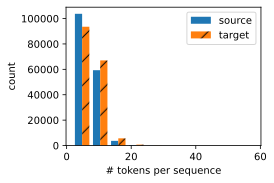

In [6]:
"""
让我们绘制每个文本序列所包含的词元数量的直方图。 在这个简单的“英－法”数据集中，大多数文本序列的词元数量少于20个。
"""
def show_list_len_pair_hist(legend,xlabel,ylabel,xlist,ylist):
    """绘制列表长度对的直方图"""
    d2l.set_figsize()
    _,_,patches=d2l.plt.hist([[len(l) for l in xlist],[len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)

show_list_len_pair_hist(['source','target'],'# tokens per sequence','count',source,target)

## 9.5.3. 词表
由于机器翻译数据集由语言对组成， 因此我们可以分别为源语言和目标语言构建两个词表。

使用单词级词元化时，词表大小将明显大于使用字符级词元化时的词表大小。

In [7]:
"""
 为了缓解这一问题，这里我们将出现次数少于2次的低频率词元 视为相同的未知（“<unk>”）词元。

 除此之外，我们还指定了额外的特定词元， 例如在小批量时用于将序列填充到相同长度的填充词元（“<pad>”）， 以及序列的开始词元（“<bos>”）和结束词元（“<eos>”）。

 这些特殊词元在自然语言处理任务中比较常用。
"""

src_vocab = d2l.Vocab(source, min_freq=2, reserved_tokens=['<pad>','<bos>','<eos>'])

len(src_vocab)

10012

## 9.5.4. 加载数据集
回想一下，语言模型中的**序列样本都有一个固定的长度**，无论这个样本是一个句子的一部分还是跨越了多个句子的一个片断。这个固定长度是由8.3节中的`num_steps`（时间步数或词元数量）参数指定的。在机器翻译中，每个样本都是由源和目标组成的文本序列对，其中的每个文本序列可能具有不同的长度。

为了提高计算效率，我们仍然可以通过**截断**（truncation）和**填充**（padding）方式实现一次只处理一个小批量的文本序列。

假设同一个小批量中的每个序列都应该具有相同的长度`num_steps`，那么如果文本序列的词元数目少于`num_steps`时，我们将继续在其末尾添加特定的“&lt;pad&gt;”词元，直到其长度达到`num_steps`；反之，我们将截断文本序列时，只取其前`num_steps`个词元，并且丢弃剩余的词元。这样，每个文本序列将具有相同的长度，以便以相同形状的小批量进行加载。



In [8]:
"""
如前所述，下面的`truncate_pad`函数将截断或填充文本序列。
"""

#@save
def truncate_pad(line,num_steps,padding_token):
    """截断或填充文本序列"""
    if len(line)>num_steps:
        return line[:num_steps]  # 截断
    return line+[padding_token] * (num_steps-len(line))  # 填充

truncate_pad(src_vocab[source[0]],10,src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [9]:
"""
现在我们定义一个函数，可以将文本序列转换成小批量数据集用于训练。

我们将特定的“<eos>”词元添加到所有序列的末尾，用于表示序列的结束。当模型通过一个词元接一个词元地生成序列进行预测时，生成的“<eos>”词元说明完成了序列输出工作。

此外，我们还记录了每个文本序列的长度，统计长度时排除了填充词元，在稍后将要介绍的一些模型会需要这个长度信息。
"""
#@save
def build_array_nmt(lines,vocab,num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines=[vocab[l] for l in lines]
    lines=[l+[vocab['<eos>']] for l in lines ]
    array=torch.tensor([truncate_pad(l,num_steps,vocab['<pad>']) for l in lines])
    valid_len=(array != vocab['<pad>']).type(torch.int32).sum(1)  # 句子的实际长度
    return array,valid_len

## 9.5.5. 训练模型

In [11]:
"""
定义load_data_nmt函数来返回数据迭代器， 以及源语言和目标语言的两种词表。
"""

#@save
def load_data_nmt(batch_size,num_steps,num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text=preprocess_nmt(read_data_nmt())
    source,target=tokenize_nmt(text,num_examples)
    src_vocab=d2l.Vocab(source,min_freq=2,reserved_tokens=['<pad>','<bos>','<eos>'])
    tgt_vocab=d2l.Vocab(target,min_freq=2,reserved_tokens=['<pad>','<bos>','<eos>'])
    src_array,src_valid_len=build_array_nmt(source,src_vocab,num_steps)
    tgt_array,tgt_valid_len=build_array_nmt(target,tgt_vocab,num_steps)
    data_arrays=(src_array,src_valid_len,tgt_array,tgt_valid_len)
    data_iter=d2l.load_array(data_arrays,batch_size)
    return data_iter,src_vocab,tgt_vocab


In [12]:
"""
下面我们读出“英语－法语”数据集中的第一个小批量数据。
"""
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2,num_steps=8)

for X,X_valid_len,Y,Y_valid_len in train_iter:
    print('X:',X.type(torch.int32),'\nX的有效长度:',X_valid_len,'\nY:',Y.type(torch.int32),'\nY的有效长度:',Y_valid_len)
    break

X: tensor([[109,  10,   4,   3,   1,   1,   1,   1],
        [  6,  18, 104,   4,   3,   1,   1,   1]], dtype=torch.int32) 
X的有效长度: tensor([4, 5]) 
Y: tensor([[91,  8,  4,  3,  1,  1,  1,  1],
        [ 6, 33, 17,  4,  3,  1,  1,  1]], dtype=torch.int32) 
Y的有效长度: tensor([4, 5])


## 9.5.6. 小结
- 机器翻译指的是将文本序列从一种语言自动翻译成另一种语言。

- 使用单词级词元化时的词表大小，将明显大于使用字符级词元化时的词表大小。为了缓解这一问题，我们可以将低频词元视为相同的未知词元。

- 通过截断和填充文本序列，可以保证所有的文本序列都具有相同的长度，以便以小批量的方式加载。